In [1]:
%matplotlib inline

In [2]:
pwd

'/mnt/c/Users/kuszi/Documents/starclass/notes'

In [3]:
import sys
#sys.path.append('../../../non_corrupt_starclass/starclass')
# This is done so starclass can be imported later on
sys.path.append('../')
#sys.path.append('../../../shap/')

In [34]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Load and format colorblind palette for use in plot_decision_regions
color_pal = sns.color_palette("colorblind", 8)
color_pal
colors_pal = LinearSegmentedColormap.from_list("colourblind", color_pal, 8)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
import pickle
import sqlite3
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
shap.initjs()

[<matplotlib.lines.Line2D at 0x7f29550cd3d0>]

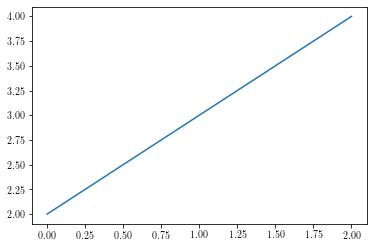

In [6]:
plt.plot([0, 1, 2], [2, 3, 4])

In [7]:
connection = sqlite3.connect('../starclass/training_sets/data/keplerq9/todo.sqlite')

In [8]:
df = pd.read_sql_query("select * from starclass_results;", connection)
labels = pd.read_sql_query("select * from diagnostics_corr;", connection)
labels['label'] = [i.split('/')[0] for i in labels['lightcurve'].values]
print(labels.head(10))
#print(df.head(10))
connection.close()

   priority               lightcurve  elaptime worker_wait_time      variance  \
0         1  APERIODIC/201131882.txt  3.736189             None  1.304668e+06   
1         2  APERIODIC/201132839.txt  3.488558             None  1.137392e+06   
2         3  APERIODIC/201133037.txt  2.768360             None  1.792990e+07   
3         4  APERIODIC/201141142.txt  3.391041             None  1.149266e+06   
4         5  APERIODIC/201142064.txt  3.083377             None  2.374183e+06   
5         6  APERIODIC/201142448.txt  3.367422             None  3.181878e+06   
6         7  APERIODIC/201147037.txt  2.730011             None  4.554971e+06   
7         8  APERIODIC/201150637.txt  2.602534             None  5.309047e+05   
8         9  APERIODIC/201153558.txt  2.896529             None  7.861922e+05   
9        10  APERIODIC/201154950.txt  2.771129             None  2.814573e+06   

      rms_hour         ptp errors      label  
0  1079.519250  266.980284   None  APERIODIC  
1   967.947135

In [9]:
labels['priority'].iloc[3800:3830] #4200]

3800    3801
3801    3802
3802    3803
3803    3804
3804    3805
3805    3806
3806    3807
3807    3808
3808    3809
3809    3810
3810    3811
3811    3812
3812    3813
3813    3814
3814    3815
3815    3816
3816    3817
3817    3818
3818    3819
3819    3820
3820    3821
3821    3822
3822    3823
3823    3824
3824    3825
3825    3826
3826    3827
3827    3828
3828    3829
3829    3830
Name: priority, dtype: int64

In [10]:
y = labels['label'].astype('U15').values #values[labels['priority'].unique()-1].astype('U15')
priority = labels['priority'].values#[df['priority'].unique()-1]
y[y == 'APERIODIC'] = 'aperiodic'
y[y == 'CONSTANT'] = 'constant'
y[y == 'RRLYR_CEPHEID'] = 'RRLyr/Ceph'
y[y == 'CONTACT_ROT'] = 'contactEB/spots'
y[y == 'DSCT_BCEP'] = 'dSct/bCep'
y[y == 'ECLIPSE'] = 'transit/eclipse'
y[y == 'GDOR_SPB'] = 'gDor/spB'
y[y == 'SOLARLIKE'] = 'solar'

In [11]:
len(priority), len(y), len(df)

(5755, 5755, 80120)

In [12]:
rfgc = df.loc[(df['classifier'] == 'rfgc'), ]#.values.reshape(len(df)//32, 8)
#slosh = df.loc[(df['classifier'] == 'slosh'), 'prob'].values.reshape(len(df)//32, 8)
#xgb = df.loc[(df['classifier'] == 'xgb'), 'prob'].values.reshape(len(df)//32, 8)

In [13]:
feature_names = [r'$f_{1}$', r'$f_{2}$', r'$f_{3}$', r'$f_{4}$', r'$f_{5}$', r'$f_{6}$', r'$A_{21}$', r'$A_{31}$', r'$\phi_{21}$', r'$\phi_{31}$', 
                 'SOM location 1', 'SOM location 2', r'$\phi$ p2p98', r'$\phi$ p2p mean', 'p2p98', 'p2p mean', r'$\psi^{2}$', 'Zero-crossings', r'$F_{p}07$', r'$F_{p}7$', r'$F_{p}20$', r'$F_{p}50$']
class_names = ['RR Lyr/Cepheid', 'Aperiodic', 'Constant', 
                      'Contact binaries/rotation', r'$\delta$ Sct/$\beta$ Cep', '$\gamma$ Dor/SPB', 
                      'Solar-like', 'Eclipsing/Transiting']

In [14]:
with open('../starclass/data/L1/keplerq9/rfgc_classifier_v01.pickle', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
#model = pickle.load('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle')

Using TensorFlow backend.


In [15]:
X = np.zeros([len(priority), 22])
for idx, i in enumerate(priority):
    X[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')

In [16]:
X_old = np.zeros([len(priority), 22])
for idx, i in enumerate(priority):
    try:
        X_old[idx,:] = np.loadtxt('../../non_corrupt_starclass/starclass/starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
    except:
        pass

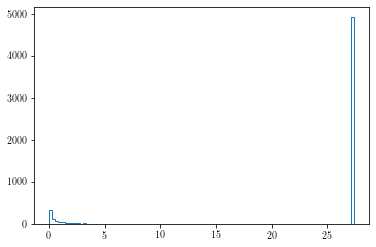

In [17]:
plt.hist(X[:,5], bins=100, histtype='step');
#plt.hist(X_old[X_old[:,0] != 0,0], bins=100, histtype='step');
plt.show()

In [18]:
bad_stars = priority[X[:,0] > 27]
len(bad_stars), len(y)

(1960, 5755)

In [19]:
len(y)

5755

In [20]:
bad_stars[-1]

5745

In [21]:
priority[y == 'RRLyr/Ceph']

array([3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999,
       4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010,
       4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021,
       4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032,
       4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043,
       4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051])

In [22]:
import matplotlib


In [23]:
#for i in range(len(priority[y == 'RRLyr/Ceph'])):

#    try:
#        plt.figure()
#        with open('../../non_corrupt_starclass/starclass/starclass/training_sets/data/keplerq9/features_cache_corr/features-'+str(priority[y == 'RRLyr/Ceph'][i])+'.pickle', 'rb') as pickle_file:
#            feature = pickle.load(pickle_file)
        #print(feature['freq1'])
        #matplotlib.use('TKAgg')
#        freq, psd = feature['powerspectrum'].standard

#        plt.plot(freq, psd)
#        with open('../starclass/training_sets/data/keplerq9/features_cache_corr/features-'+str(priority[y == 'RRLyr/Ceph'][i])+'.pickle', 'rb') as pickle_file:
#            feature = pickle.load(pickle_file)
#        print(feature['freq1'])
#        print(labels.iloc[priority[y == 'RRLyr/Ceph'][i]])
        #matplotlib.use('TKAgg')
#        freq, psd = feature['powerspectrum'].standard
#        plt.plot(freq, psd)
        #plt.axvline(feature['freq1'], color='r', linestyle='--')
#        plt.xscale('log')
#        plt.yscale('log')
#        plt.show()
#    except:
#        pass

In [24]:
#skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#for train_index, test_index in skf.split(priority, y):
#    X_train = np.zeros([len(train_index), 22])
#    X_test = np.zeros([len(test_index), 22])
#    y_train = y[train_index]
#    y_test = y[test_index]
#    print(test_index)
#    train = priority[train_index]
#    for idx, i in enumerate(train):
#        X_train[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
#    test = priority[test_index]
#    for idx, i in enumerate(test):
#        X_test[idx,:] = np.loadtxt('../starclass/training_sets/data/keplerq9/features_cache_corr/rfgc_features/'+str(i)+'.txt')
#    break

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2359230457)

In [26]:
print(*zip(feature_names, model.feature_importances_))

('$f_{1}$', 0.0797308700677888) ('$f_{2}$', 0.0583011747645313) ('$f_{3}$', 0.04761888440933837) ('$f_{4}$', 0.046374779136774034) ('$f_{5}$', 0.055356653981644924) ('$f_{6}$', 0.07252027081920122) ('$A_{21}$', 0.011479989023545278) ('$A_{31}$', 0.013868820328393741) ('$\\phi_{21}$', 0.002067555556784951) ('$\\phi_{31}$', 0.002306497214817786) ('SOM location 1', 0.07057788167702501) ('SOM location 2', 0.05707948419975362) ('$\\phi$ p2p98', 0.015761316932791904) ('$\\phi$ p2p mean', 0.0143031460955199) ('p2p98', 0.04292721163815213) ('p2p mean', 0.05018355704820791) ('$\\psi^{2}$', 0.07720073670962745) ('Zero-crossings', 0.08751813616451318) ('$F_{p}07$', 0.0770966821174531) ('$F_{p}7$', 0.05284116867189052) ('$F_{p}20$', 0.029957185299015865) ('$F_{p}50$', 0.03492799814322899)


In [27]:
preds = model.predict(X_test)

Feature ranking:
1. feature Zero-crossings (0.08751813616451318)
2. feature $f_{1}$ (0.0797308700677888)
3. feature $\psi^{2}$ (0.07720073670962745)
4. feature $F_{p}07$ (0.0770966821174531)
5. feature $f_{6}$ (0.07252027081920122)
6. feature SOM location 1 (0.07057788167702501)
7. feature $f_{2}$ (0.0583011747645313)
8. feature SOM location 2 (0.05707948419975362)
9. feature $f_{5}$ (0.055356653981644924)
10. feature $F_{p}7$ (0.05284116867189052)
11. feature p2p mean (0.05018355704820791)
12. feature $f_{3}$ (0.04761888440933837)
13. feature $f_{4}$ (0.046374779136774034)
14. feature p2p98 (0.04292721163815213)
15. feature $F_{p}50$ (0.03492799814322899)
16. feature $F_{p}20$ (0.029957185299015865)
17. feature $\phi$ p2p98 (0.015761316932791904)
18. feature $\phi$ p2p mean (0.0143031460955199)
19. feature $A_{31}$ (0.013868820328393741)
20. feature $A_{21}$ (0.011479989023545278)
21. feature $\phi_{31}$ (0.002306497214817786)
22. feature $\phi_{21}$ (0.002067555556784951)


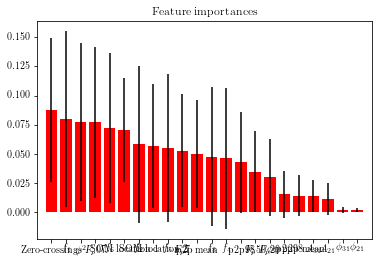

In [262]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("{}. feature {} ({})".format(f + 1, np.array(feature_names)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [28]:
accuracy_score(preds, y_test)

0.9722222222222222

In [257]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

starclass meta


In [294]:
""" Summary plots of SHAP values across a whole dataset.
"""

from shap.plots import labels
from shap.plots import colors

# TODO: remove unused title argument / use title argument
def summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None,
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 color_bar=True, auto_size_plot=True, layered_violin_max_num_bins=20, class_names=None,
                 color_bar_label=labels["FEATURE_VALUE"]):
    """Create a SHAP summary plot, colored by feature values when they are provided.
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    feature_names : list
        Names of the features (length # features)
    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)
    plot_type : "dot" (default for single output), "bar" (default for multi-output), "violin",
        or "compact_dot".
        What type of summary plot to produce. Note that "compact_dot" is only used for
        SHAP interaction values.
    """

    multi_class = False
    if isinstance(shap_values, list):
        multi_class = True
        if plot_type is None:
            plot_type = "bar" # default for multi-output explanations
        assert plot_type == "bar", "Only plot_type = 'bar' is supported for multi-output explanations!"
    else:
        if plot_type is None:
            plot_type = "dot" # default for single output explanations
        assert len(shap_values.shape) != 1, "Summary plots need a matrix of shap_values, not a vector."

    # default color:
    if color is None:
        if plot_type == 'layered_violin':
            color = "coolwarm"
        elif multi_class:
            color = lambda i: colors.red_blue_circle(i/len(shap_values))
        else:
            color = colors.blue_rgb

    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = (shap_values[0].shape[1] if multi_class else shap_values.shape[1])

    if features is not None:
        shape_msg = "The shape of the shap_values matrix does not match the shape of the " \
                    "provided data matrix."
        if num_features - 1 == features.shape[1]:
            assert False, shape_msg + " Perhaps the extra column in the shap_values matrix is the " \
                          "constant offset? Of so just pass shap_values[:,:-1]."
        else:
            assert num_features == features.shape[1], shape_msg

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(num_features)])

    # plotting SHAP interaction values
    if not multi_class and len(shap_values.shape) == 3:

        if plot_type == "compact_dot":
            new_shap_values = shap_values.reshape(shap_values.shape[0], -1)
            new_features = np.tile(features, (1, 1, features.shape[1])).reshape(features.shape[0], -1)

            new_feature_names = []
            for c1 in feature_names:
                for c2 in feature_names:
                    if c1 == c2:
                        new_feature_names.append(c1)
                    else:
                        new_feature_names.append(c1 + "* - " + c2)

            return summary_plot(
                new_shap_values, new_features, new_feature_names,
                max_display=max_display, plot_type="dot", color=color, axis_color=axis_color,
                title=title, alpha=alpha, show=show, sort=sort,
                color_bar=color_bar, auto_size_plot=auto_size_plot, class_names=class_names,
                color_bar_label="*" + color_bar_label
            )

        if max_display is None:
            max_display = 7
        else:
            max_display = min(len(feature_names), max_display)

        sort_inds = np.argsort(-np.abs(shap_values.sum(1)).sum(0))

        # get plotting limits
        delta = 1.0 / (shap_values.shape[1] ** 2)
        slow = np.nanpercentile(shap_values, delta)
        shigh = np.nanpercentile(shap_values, 100 - delta)
        v = max(abs(slow), abs(shigh))
        slow = -v
        shigh = v

        plt.figure(figsize=(1.5 * max_display + 1, 0.8 * max_display + 1))
        plt.subplot(1, max_display, 1)
        proj_shap_values = shap_values[:, sort_inds[0], sort_inds]
        proj_shap_values[:, 1:] *= 2  # because off diag effects are split in half
        summary_plot(
            proj_shap_values, features[:, sort_inds] if features is not None else None,
            feature_names=feature_names[sort_inds],
            sort=False, show=False, color_bar=False,
            auto_size_plot=False,
            max_display=max_display
        )
        plt.xlim((slow, shigh))
        plt.xlabel("")
        title_length_limit = 11
        plt.title(shorten_text(feature_names[sort_inds[0]], title_length_limit))
        for i in range(1, min(len(sort_inds), max_display)):
            ind = sort_inds[i]
            plt.subplot(1, max_display, i + 1)
            proj_shap_values = shap_values[:, ind, sort_inds]
            proj_shap_values *= 2
            proj_shap_values[:, i] /= 2  # because only off diag effects are split in half
            summary_plot(
                proj_shap_values, features[:, sort_inds] if features is not None else None,
                sort=False,
                feature_names=["" for i in range(len(feature_names))],
                show=False,
                color_bar=False,
                auto_size_plot=False,
                max_display=max_display
            )
            plt.xlim((slow, shigh))
            plt.xlabel("")
            if i == min(len(sort_inds), max_display) // 2:
                plt.xlabel(labels['INTERACTION_VALUE'])
            plt.title(shorten_text(feature_names[ind], title_length_limit))
        plt.tight_layout(pad=0, w_pad=0, h_pad=0.0)
        plt.subplots_adjust(hspace=0, wspace=0.1)
        if show:
            plt.show()
        return

    if max_display is None:
        max_display = 20

    if sort:
        # order features by the sum of their effect magnitudes
        if multi_class:
            feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=0), axis=0))
        else:
            feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.flip(np.arange(min(max_display, num_features)), 0)

    row_height = 0.4
    if auto_size_plot:
        plt.gcf().set_size_inches(8, len(feature_order) * row_height + 1.5)
    plt.axvline(x=0, color="#999999", zorder=-1)

    if multi_class and plot_type == "bar":
        if class_names is None:
            class_names = ["Class "+str(i) for i in range(len(shap_values))]
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        left_pos = np.zeros(len(feature_inds))

        class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
        max_shap_per_class = np.array([np.max(np.abs(shap_values[i]).mean(0)) for i in range(len(shap_values))])
        #print(len(max_shap_per_feature))
        
        for i,ind in enumerate(class_inds):
            global_shap_values = np.mean(np.abs(shap_values[ind]), axis=0)
            #print(np.shape(global_shap_values))
            #global_shap_values == 
            #print(np.where(np.in1d(global_shap_values, max_shap_per_feature))[0])
            #hatch = np.array(['/']*len(global_shap_values))
            #hatch[np.where(np.in1d(global_shap_values, max_shap_per_feature))[0]] = '*'
            #print(hatch)
            #print(feature_inds)
            print(class_names[ind])
            for j, idx in enumerate(feature_inds):
                if j == 0:
                    if np.in1d(global_shap_values[feature_inds[j]], max_shap_per_class)[0] == True:
                        print("Hatching")
                        plt.barh(y_pos[j], global_shap_values[feature_inds[j]], 0.7, left=left_pos[j], align='center', color=color(i), label=class_names[ind] if j == 0 else "", hatch='xxx')
                    else:
                        plt.barh(y_pos[j], global_shap_values[feature_inds[j]], 0.7, left=left_pos[j], align='center', color=color(i), label=class_names[ind] if j == 0 else "")#, hatch=)
                else:
                    if np.in1d(global_shap_values[feature_inds[j]], max_shap_per_class)[0] == True:
                        print("Hatching")
                        plt.barh(y_pos[j], global_shap_values[feature_inds[j]], 0.7, left=left_pos[j], align='center', color=color(i), hatch='xxx')
                    else:
                        plt.barh(y_pos[j], global_shap_values[feature_inds[j]], 0.7, left=left_pos[j], align='center', color=color(i))#, hatch=)
                #print(global_shap_values[feature_inds[j]])
            #    plt.barh(y_pos[j], global_shap_values[feature_inds[j]], 0.7, left=left_pos[j], align='center', color=color(i), label=class_names[ind] if j == 0 else "")#, hatch=)
            #print(global_shap_values[feature_inds])
            #plt.barh(
            #    y_pos, global_shap_values[feature_inds], 0.7, left=left_pos, align='center',
            #    color=color(i), label=class_names[ind],
            #)
            #print(left_pos)
            left_pos += global_shap_values[feature_inds]
        #plt.yticks(y_pos, fontsize=13)
            #if i == 1:
            #    break
        plt.gca().set_yticklabels([feature_names[i] for i in feature_inds])
        plt.legend(frameon=False, fontsize=12)

    # draw the color bar
    #if color_bar and features is not None and plot_type != "bar" and \
    #        (plot_type != "layered_violin" or color in plt.cm.datad):
    #    import matplotlib.cm as cm
    #    m = cm.ScalarMappable(cmap=colors.red_blue if plot_type != "layered_violin" else plt.get_cmap(color))
    #    m.set_array([0, 1])
    #    cb = plt.colorbar(m, ticks=[0, 1], aspect=1000)
    #    cb.set_ticklabels([labels['FEATURE_VALUE_LOW'], labels['FEATURE_VALUE_HIGH']])
    #    cb.set_label(color_bar_label, size=12, labelpad=0)
    #    cb.ax.tick_params(labelsize=11, length=0)
    #    cb.set_alpha(1)
    #    cb.outline.set_visible(False)
    #    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
    #    cb.ax.set_aspect((bbox.height - 0.9) * 20)
    #    # cb.draw_all()

    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().tick_params(color=axis_color, labelcolor=axis_color)
    plt.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=13)
    if plot_type != "bar":
        plt.gca().tick_params('y', length=20, width=0.5, which='major')
    plt.gca().tick_params('x', labelsize=11)
    plt.ylim(-1, len(feature_order))
    if plot_type == "bar":
        plt.xlabel(labels['GLOBAL_VALUE'], fontsize=13)
    else:
        plt.xlabel(labels['VALUE'], fontsize=13)
    if show:
        plt.show()

def shorten_text(text, length_limit):
    if len(text) > length_limit:
        return text[:length_limit - 3] + "..."
    else:
        return text

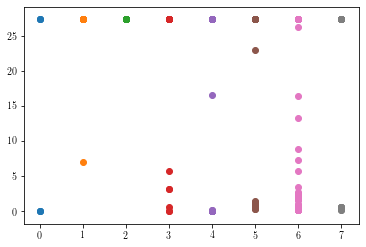

In [295]:
#X_test[:,5], 
j = 5
#for i in np.unique(y_test):
#    plt.hist(X_test[y_test == i, j], bins=10, density=True, histtype='step', label=i);
#plt.ylim(0, 0.5)
#plt.legend(loc='best');
#plt.show()
plt.figure(2)
for idx, i in enumerate(np.unique(y_test)):
    plt.scatter([idx]*len(X_test[y_test == i, j]), X_test[y_test == i, j], label=i);
#plt.ylim(0, 0.5)
#plt.legend(loc='best');
plt.show()

Contact binaries/rotation
Hatching
Solar-like
Hatching
Aperiodic
Hatching
$\delta$ Sct/$\beta$ Cep
Hatching
Constant
Hatching
Eclipsing/Transiting
Hatching
$\gamma$ Dor/SPB
Hatching
RR Lyr/Cepheid
Hatching


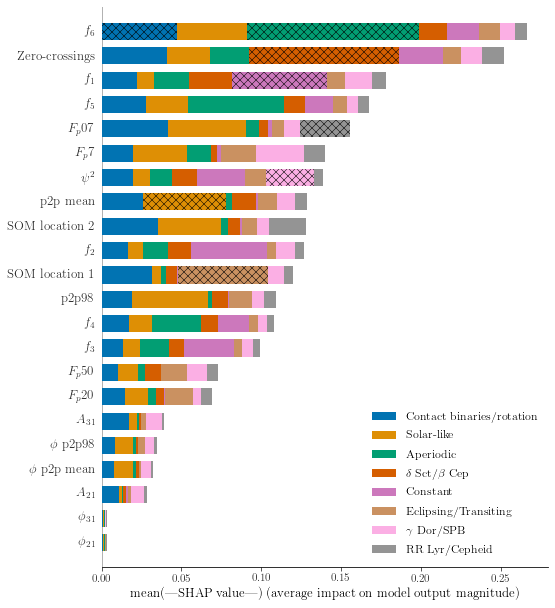

In [296]:
#tuple(color_pal)
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = 'k'

fig = summary_plot(shap_values, X_train, 
                  feature_names=feature_names,
                  class_names=class_names, max_display=len(feature_names), plot_type="bar", color=colors_pal)
#plt.savefig('RFGC_feature_importance.pdf', bbox_inches='tight')

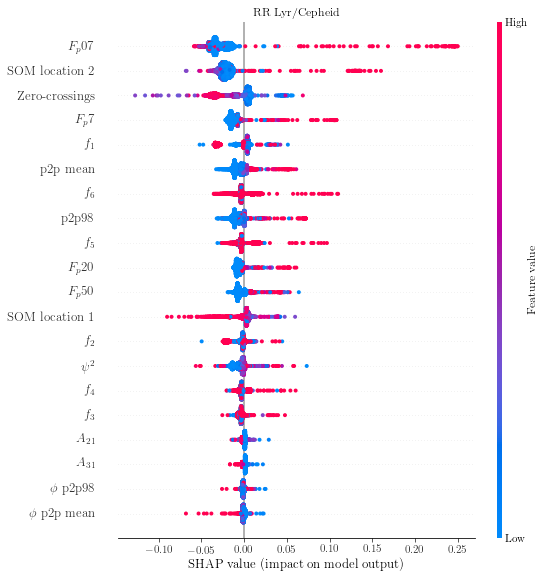

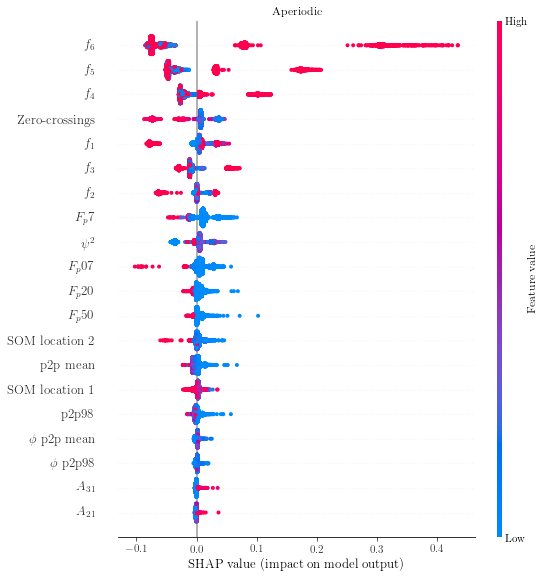

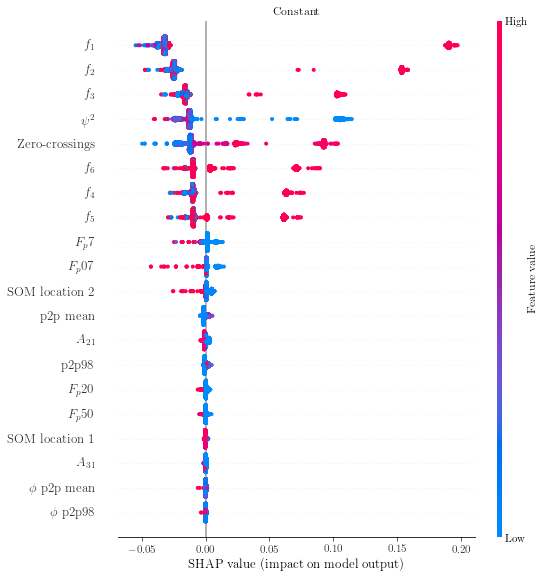

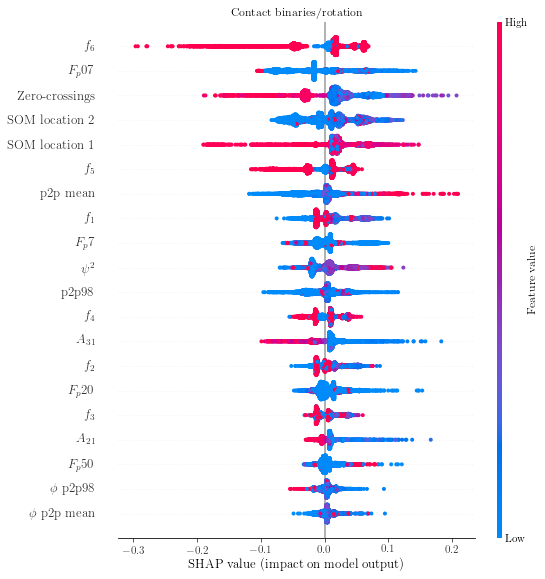

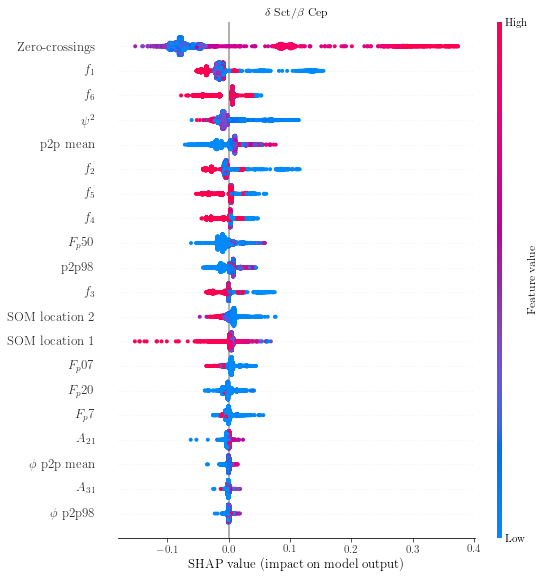

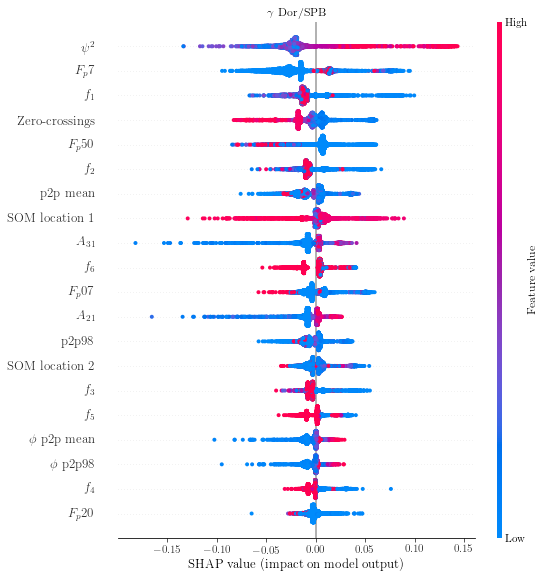

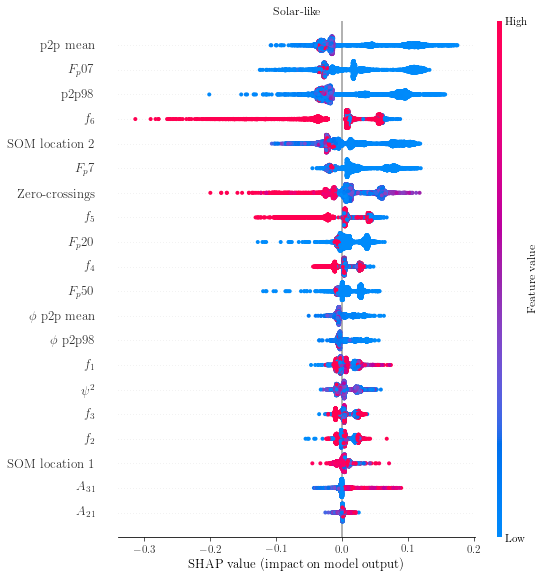

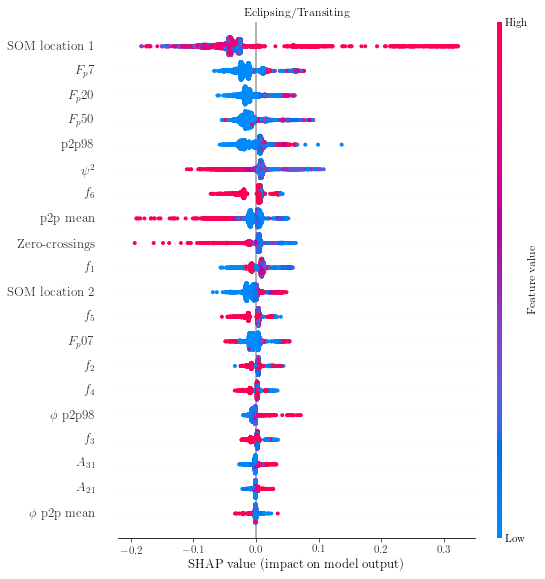

In [290]:
for i in range(len(class_names)):
    plt.figure(i)
    plt.title(class_names[i])
    shap.summary_plot(shap_values[i], X_train, 
                      feature_names=feature_names,
                      class_names=class_names[i])#, plot_type="bar")
    #plt.savefig(class_names[i]+'.png', bbox_inches='tight')
    plt.show()

(5179, 22)


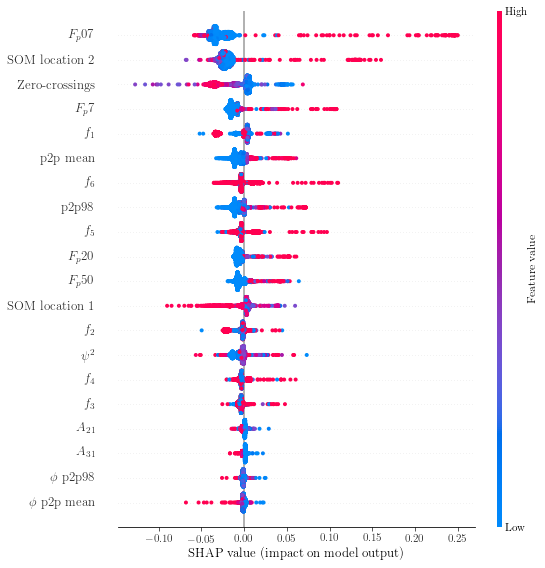

In [288]:
for idx, i in enumerate(np.unique(y_train)):
    print(np.shape(shap_values[idx]))
    shap.summary_plot(shap_values[idx], X_train, feature_names=feature_names,
                      class_names=class_names[idx])
    break